# Causal discovery
Causal discovery aims to infer causal structure from data. In other words, given a dataset, derive a causal model that describes the dataset.

Causal-Learn is a Python package for causal discovery that is being developed by the Causal-learn group at Carnegie Mellon University. The package implements both classical and state-of-the-art causal discovery algorithms, and continues to be under active development. Causal-learn can be viewed as a Python translation.

https://www.sciencedirect.com/science/article/pii/S2352711022002126

https://causal-learn.readthedocs.io/en/latest/getting_started.html

In [2]:
#pip install causal-learn
import causallearn

In [3]:
import pandas as pd
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
#!pip install "pandas<2.0.0"

Dataset from: https://archive.ics.uci.edu/ml/datasets/census+income

In [4]:
df = pickle.load( open( "df_causal_discovery.p", "rb" ) )

data = np.array(df)

df.head()

,age,hours-per-week,hasGraduateDegree,inRelationship,isWhite,isFemale,greaterThan50k
0,39,40,0,0,1,0,0
1,50,13,0,1,1,0,0
2,38,40,0,0,1,0,0
3,53,40,0,1,0,0,0
5,37,40,1,0,1,1,0


In [5]:
from causallearn.graph.GeneralGraph import GeneralGraph

# Visulaization of Causal graph using Networkx
# cg to nx : a CausalGraph object, where cg.G.graph[j,i]=1 and cg.G.graph[i,j]=-1 indicate i –> j; cg.G.graph[i,j] = cg.G.graph[j,i] = -1 indicate i — j; cg.G.graph[i,j] = cg.G.graph[j,i] = 1 indicates i <-> j.

def to_nx(cl_graph: GeneralGraph):
    
        nx_graph = nx.DiGraph()
        nodes = cl_graph.get_nodes()
        
        for i, node in enumerate(nodes):
            nx_graph.add_node(i)
            
        for edge in cl_graph.get_graph_edges():
            node1 = edge.get_node1()
            node2 = edge.get_node2()
            node1_idx = nodes.index(node1)
            node2_idx = nodes.index(node2)
            if(cl_graph.graph[node1_idx, node2_idx] == -1) and (cl_graph.graph[node2_idx, node1_idx] == 1):
                # directed edge
                nx_graph.add_edge(node1_idx, node2_idx, color='b')
            elif(cl_graph.graph[node1_idx, node2_idx] == 1) and (cl_graph.graph[node2_idx, node1_idx] == -1):
                # directed edge
                nx_graph.add_edge(node2_idx, node1_idx, color='b')
            elif(cl_graph.graph[node1_idx, node2_idx] == 1) and (cl_graph.graph[node2_idx, node1_idx] == 1):
                # bi-directed edge
                # The bidirected edge between node1 and node2 indicates that there is at least one unmeasured confounder of them.
                nx_graph.add_edge(node2_idx, node1_idx, color='r')
                nx_graph.add_edge(node1_idx, node2_idx, color='r')
            elif(cl_graph.graph[node1_idx, node2_idx] == -1) and (cl_graph.graph[node2_idx, node1_idx] == -1):
                # undirected edge
                nx_graph.add_edge(node2_idx, node1_idx, color='g')
                nx_graph.add_edge(node1_idx, node2_idx, color='g')
        return nx_graph


### Constraint-based method - PC algorithm
The PC algorithm named after its authors Peter Spirtes and Clark Glymour. This algorithm uses the conditional independence test to remove the link between two variables if they are statistically independent or conditionally independent. 

  0%|          | 0/7 [00:00<?, ?it/s]

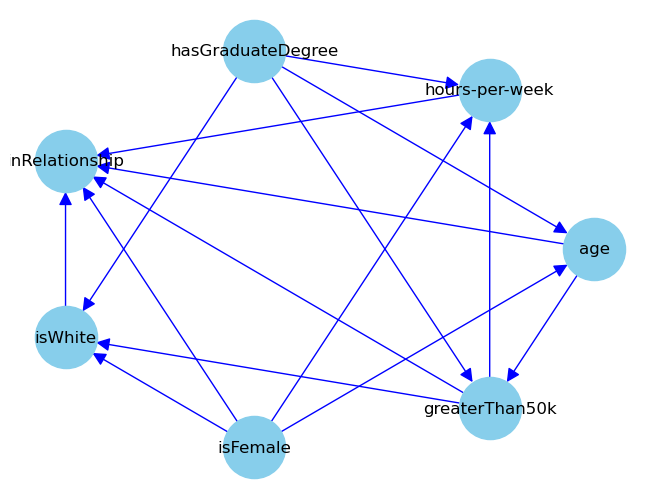

In [6]:
from causallearn.search.ConstraintBased.PC import pc

# default parameters
#cg = pc(data)
cg = pc(data, 0.05, 'fisherz', True, 0, -1) 

# or customized parameters
#cg = pc(data, alpha, indep_test, stable, uc_rule, uc_priority, mvpc, correction_name, background_knowledge, verbose, show_progress)

# visulization of causal graph
nx_graph = to_nx(cg.G)
pos = nx.circular_layout(nx_graph)
edges = nx_graph.edges()
colors = [nx_graph[u][v]['color'] for u,v in edges]

labeldict = {i:c for i,c in enumerate(df.columns)}
nx.draw(nx_graph, pos, labels=labeldict, with_labels=True, edge_color=colors, arrowsize=20, node_color='skyblue', node_size=2000)


The arrow between age and hasGraduateDegree is flipped, which is questionable since this suggests having a graduate degree has a causal effect on one’s age!

Possible values of the independence test method (indep_test) are as follows. The default value for indep_test at PC is ‘fisherz’.
- “fisherz”: Fisher’s Z conditional independence test.
- “chisq”: Chi-squared conditional independence test.
- “gsq”: G-squared conditional independence test.
- “kci”: kernel-based conditional independence test. (As a kernel method, its complexity is cubic in the sample size, so it might be slow if the same size is not small.)
- “mv_fisherz”: Missing-value Fisher’s Z conditional independence test.

Other information about the parameters: 
https://causal-learn.readthedocs.io/en/latest/search_methods_index/Constraint-based%20causal%20discovery%20methods/PC.html


<div class="alert alert-block alert-warning">
    
Task: Try the following variation of PC:
- try two different values of alpha, 0.05 and 0.9. How the results are changes?  
- try G-squared conditional independence test and compare the results.
- select a subset of data with 500 samples and then try kci test with folowing parameters: 'kci', kernelZ='Polynomial', approx=True, est_width='median'

</div>

  0%|          | 0/7 [00:00<?, ?it/s]

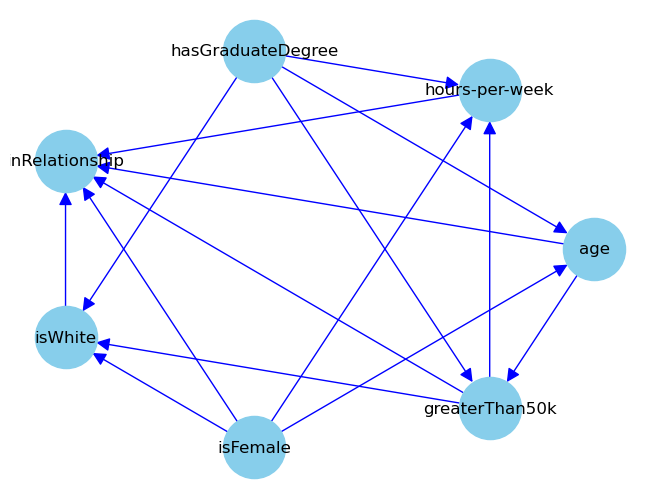

In [7]:
cg = pc(
    data,
    alpha=0.05, 
    #indep_test=["fisherz", "chisq", "gsq", "kci", "mv_fisherz"][2], 
    #fisherz is default!
    stable=True,
    uc_rule=0, # 0 to 4
    uc_priority=-1, # -1 to 4
    mvpc=False,
)


# visualization of causal graph
nx_graph = to_nx(cg.G)
pos = nx.circular_layout(nx_graph)
edges = nx_graph.edges()
colors = [nx_graph[u][v]['color'] for u,v in edges]

labeldict = {i:c for i,c in enumerate(df.columns)}
nx.draw(nx_graph, pos, labels=labeldict, with_labels=True, edge_color=colors, arrowsize=20, node_color='skyblue', node_size=2000)

# A lower alpha means a stricter threshold for determining conditional independence, 
#while a higher alpha allows for more leniency. In this case, when we increase alpha,
#some bidirectional arrows are introduced which means ambiguity of causal relations.
#That could be an improvement, if previously absurd associations were found. For 
#example that being female causes you to be white and such. However, ideally you
#would be looking for a graph without ambiguity and with the least amount of associations.

#Note:The kci is a few boxes further down and seems to better support reason!


  0%|          | 0/7 [00:00<?, ?it/s]

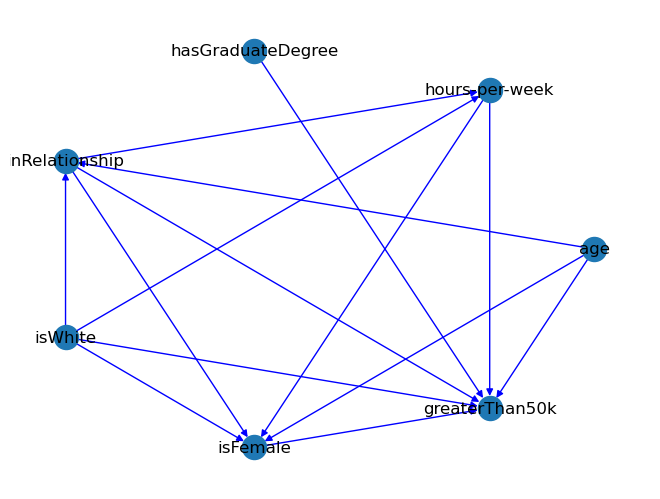

In [7]:
# For G-squared test
cg = pc(
    data,
    alpha=0.05,
    indep_test="gsq",  # G-squared test
    stable=True,
    uc_rule=0,
    uc_priority=-1,
    mvpc=False,
)
# visualization of causal graph
nx_graph = to_nx(cg.G)
pos = nx.circular_layout(nx_graph)
edges = nx_graph.edges()
colors = [nx_graph[u][v]['color'] for u,v in edges]

labeldict = {i:c for i,c in enumerate(df.columns)}
nx.draw(nx_graph, pos, labels=labeldict, with_labels=True, edge_color=colors)

<div class="alert alert-block alert-warning">
Do you think the result of the PC using G-squared is better than Fisher-z test? 
</div>

In [8]:
#gsq test introduced less ambiguity than fisherz at alpha 0.9 for example. 
#But at low alpha, the results are similar, no bidirectional arrows and same amount of edges removed.
#Results appear logically wrong in both cases.

  0%|          | 0/7 [00:00<?, ?it/s]

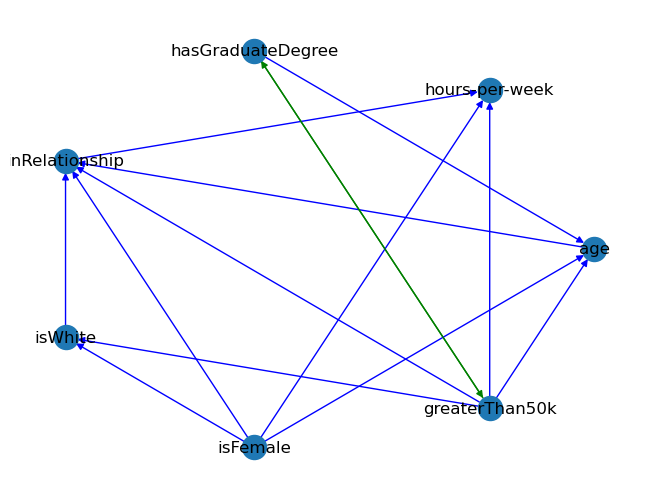

In [8]:
# Fisher z test but with missing values, and small alpha, still irrational associations
cg = pc(
    data,
    alpha=0.00000000001,
    indep_test="mv_fisherz",
    stable=True,
    uc_rule=0,
    uc_priority=-1,
    mvpc=False,
)
# visualization of causal graph
nx_graph = to_nx(cg.G)
pos = nx.circular_layout(nx_graph)
edges = nx_graph.edges()
colors = [nx_graph[u][v]['color'] for u,v in edges]

labeldict = {i:c for i,c in enumerate(df.columns)}
nx.draw(nx_graph, pos, labels=labeldict, with_labels=True, edge_color=colors)

  0%|          | 0/7 [00:00<?, ?it/s]

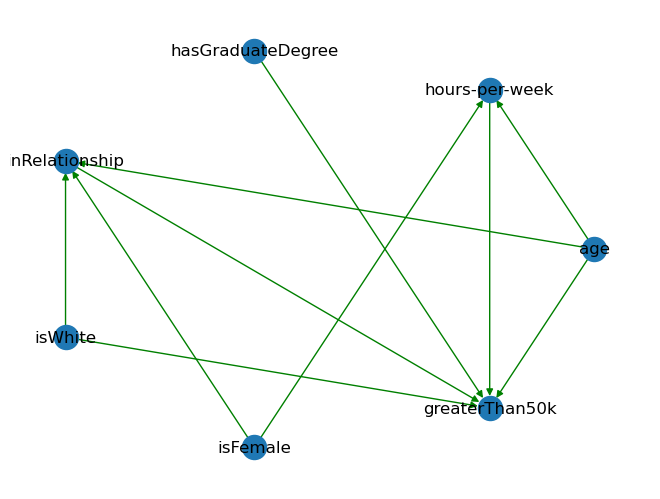

In [25]:
#!pip install pgmpy
# Select a subset of data with 500 samples
subset_indices = np.random.choice(data.shape[0], size=1000, replace=False)
subset_data = data[subset_indices, :]

# Run KCI test
cg_kci = pc(
    subset_data,
    alpha=0.05,
    indep_test="kci",
    kernelZ="Polynomial",
    approx=True,
    est_width="median",
    stable=True,
    uc_rule=0,
    uc_priority=-1,
    mvpc=False,
)

import networkx as nx
#from pgmpy.estimators import to_nx #defined previously.. ?

# Visualization for KCI test
nx_graph_kci = to_nx(cg_kci.G)
pos_kci = nx.circular_layout(nx_graph_kci)

labeldict = {i:c for i,c in enumerate(df.columns)}
edges = nx_graph.edges()
colors = [nx_graph[u][v]['color'] for u,v in edges]

nx.draw(nx_graph_kci, pos_kci, labels=labeldict, with_labels=True, edge_color=colors)

### Score-based method - GES algorithm
The Greedy Equivalence Search (GES) algorithm starts with an empty graph and iteratively adds directed edges such that the improvement in a model fitness measure (i.e. score) is maximized. An example score is the Bayesian Information Criterion (BIC).

Instead of beginning with a complete undirected graph, as in PC and FCI, the Greedy Equivalence Search (GES) (Chickering, 2003) starts with an empty graph, and adds currently needed edges, and then eliminates unnecessary edges in a pattern. At each step in the algorithm as decision is made as to whether adding a directed edge to the graph will increase fit measured by some quasi-Bayesian score such as BIC, or even by the Z score of a statistical hypothesis test, the edge that most improves fit is added. The resulting model is then mapped to the corresponding Markov equivalence class, and the procedure continued. When the score can no longer be improved, the GES algorithm then asks, edge by edge, which edge removal, if any, will most improve the score, until no further edges can thus be removed. The GES procedure is not so easy to illustrate as is PC, because its trajectory depends on the relative strengths of the associations and conditional associations of the variables. In the large sample limit, however, the two algorithms converge on the same Markov Equivalence Class under assumptions that are nearly the same. On finite samples, the algorithms may give different results, and there is as yet no GES style algorithm for cases with unknown confounders. GFCI (Ogarrio et al., 2016), a combination of GES and FCI, using GES to find a supergraph of the skeleton and FCI to prune the supergraph of the skeleton and find the orientations. GFCI has, however, proved more accurate in many simulations than the original FCI algorithm.



In [9]:
from causallearn.search.ScoreBased.GES import ges

# default parameters
Record = ges(data) #  Default: ‘local_score_BIC’


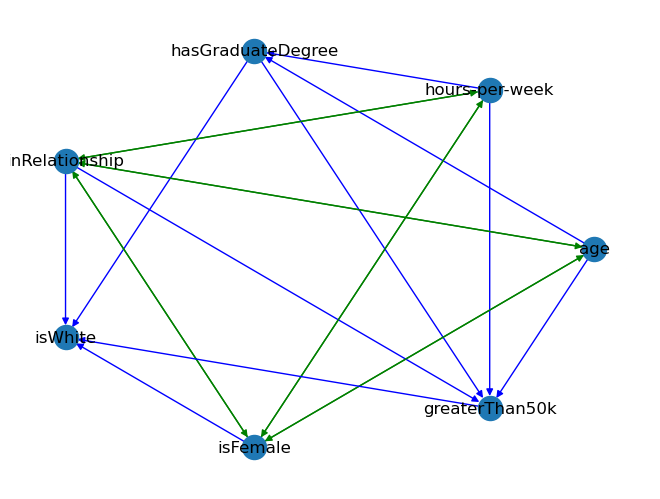

In [10]:
nx_graph = to_nx(Record['G'])
pos = nx.circular_layout(nx_graph)
edges = nx_graph.edges()
colors = [nx_graph[u][v]['color'] for u,v in edges]

labeldict = {i:c for i,c in enumerate(df.columns)}
nx.draw(nx_graph, pos, labels=labeldict, with_labels=True, edge_color=colors)



<div class="alert alert-block alert-warning">
Try GES algorithm with one of score fundtions that is different with the default.  

https://causal-learn.readthedocs.io/en/latest/search_methods_index/Score-based%20causal%20discovery%20methods/GES.html
</div>

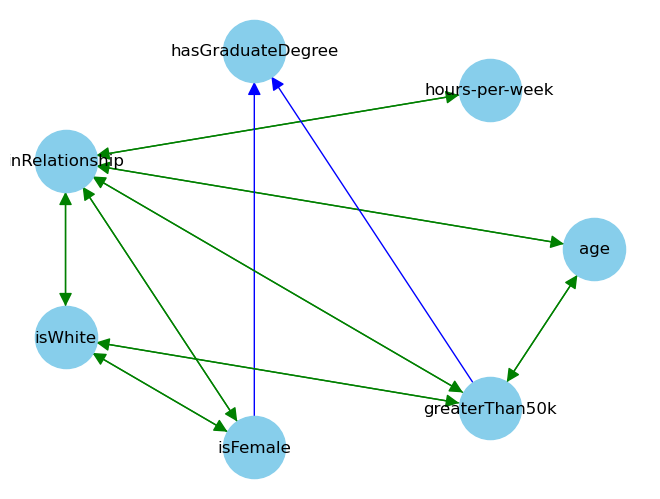

In [8]:
from causallearn.search.ScoreBased.GES import ges
from causallearn.search.ScoreBased.GES import local_score_BDeu

# custom parameters
max_parents_value = None
other_parameters_value = None

# Call the ges function with local_score_BDeu as the scoring function
Record = ges(
    data,
    score_func='local_score_BDeu',
    maxP=max_parents_value,
    parameters=other_parameters_value,
)

#Visualize
nx_graph = to_nx(Record['G'])
pos = nx.circular_layout(nx_graph)
edges = nx_graph.edges()
colors = [nx_graph[u][v]['color'] for u,v in edges]
labeldict = {i:c for i,c in enumerate(df.columns)}
nx.draw(nx_graph, pos, labels=labeldict, with_labels=True, edge_color=colors, arrowsize=20, node_color='skyblue', node_size=2000)